In [1]:
import torch
import pandas as pd
import numpy as np
from d2l import torch as d2l
from torch import nn
from torch.utils import data
# from sklearn.model_selection import train_test_split


In [2]:
# 加载下载的数据集
train_data = pd.read_csv('../california-house-prices/train.csv')
test_data = pd.read_csv('../california-house-prices/test.csv')

In [3]:
# 打印类型为非数值的每列有多少个不同值，因为one-hot编码不能对太多不同值编码
non_numeric_columns = train_data.select_dtypes(exclude=['number'])
print(non_numeric_columns.columns)  # 有21列是字符类型或者是字符和数字混合列
unique_counts = non_numeric_columns.apply(pd.Series.nunique).sort_values()
print(unique_counts)

Index(['Address', 'Summary', 'Type', 'Heating', 'Cooling', 'Parking',
       'Bedrooms', 'Region', 'Elementary School', 'Middle School',
       'High School', 'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Laundry features', 'Parking features',
       'Listed On', 'Last Sold On', 'City', 'State'],
      dtype='object')
State                      2
Type                     158
Bedrooms                 264
Cooling features         311
Middle School            488
Cooling                  540
High School              630
City                     929
Region                   949
Heating features        1121
Flooring                1347
Elementary School       1717
Heating                 1859
Laundry features        1975
Listed On               2467
Appliances included     4583
Parking features        4959
Parking                 5112
Last Sold On            6113
Summary                46787
Address                47325
dtype: int64


In [4]:
# 定义一个函数，用于判断列中是否包含多种数据类型
def is_mixed_type(col):
    # 通过 set 保存每列中唯一的数据类型
    return len(set(col.apply(type))) > 1

# 找出混合列
mixed_columns = non_numeric_columns.apply(is_mixed_type)

In [5]:
# 得到混合列和纯字符列，混合列需要看看哪些能成为数字列，字符列要看看哪些种类少可以做one-hot
# print(mixed_columns[mixed_columns])  # 混合类型
# print(train_data[mixed_columns[mixed_columns].index].iloc[:4,:])
mixed_columns_data = train_data[mixed_columns[mixed_columns].index]
string_column_data = train_data[mixed_columns[mixed_columns==False].index]

In [6]:
unique_counts = string_column_data.apply(pd.Series.nunique).sort_values()
print(unique_counts)
# 保留State字段其他都太大了不好做one-hot，type字段可以做标签编码
print(mixed_columns[mixed_columns].index)
print(train_data['Last Sold On'].nunique())

State            2
Type           158
City           929
Listed On     2467
Address      47325
dtype: int64
Index(['Summary', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Region',
       'Elementary School', 'Middle School', 'High School', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Last Sold On'],
      dtype='object')
6113


In [7]:
def pre_process(data):
    numeric_colmnu_name = data.select_dtypes(include='number')
    if 'Sold Price' in numeric_colmnu_name.columns:
        numeric_colmnu_name = numeric_colmnu_name.drop('Sold Price',axis=1)
    new_data = data[numeric_colmnu_name.columns]
    # 混合列中对Cooling,Heating进行标签编码
    if 'Cooling' in data.columns:
        col,unique = pd.factorize(data['Cooling'])
        col_series = pd.Series(col, name='Cooling_encoded')
        new_data = pd.concat([new_data,col_series],axis=1) # 列相加
    if 'Heating' in data.columns:
        col,unique = pd.factorize(data['Heating'])
        col_series = pd.Series(col, name='Heating_encoded')
        new_data = pd.concat([new_data,col_series],axis=1) # 列相加
    if 'State' in data.columns:
        new_data = pd.concat([pd.get_dummies(data['State'],dummy_na=True),new_data],axis=1)
    if 'Bedrooms' in data.columns:
        bedrooms = pd.to_numeric(data['Bedrooms'], errors='coerce').fillna(0) # 混合列，字符串转为Nan再转0
        new_data = pd.concat([new_data,bedrooms],axis=1) 
    if 'Id' in new_data.columns:
        new_data = new_data.drop('Id',axis=1)

    if 'Lot' in new_data.columns:
        new_data = new_data.drop('Lot',axis=1)
    if 'Total interior livable area' in new_data.columns:
        new_data = new_data.drop('Total interior livable area',axis=1)
    if 'Zip' in new_data.columns:
        new_data = new_data.drop('Zip',axis=1)
    if 'Annual tax amount' in new_data.columns:
        new_data = new_data.drop('Annual tax amount',axis=1)
    if 'nan' in new_data.columns:
        new_data = new_data.drop('nan',axis=1)
    if 'Garage spaces' in new_data.columns:
        new_data = new_data.drop('Garage spaces',axis=1)
    if 'Tax assessed value' in new_data.columns:
        new_data = new_data.drop('Tax assessed value',axis=1)
               
    return new_data

y = train_data['Sold Price']
train_data = pre_process(train_data)
valid_data = pre_process(test_data)

train_data = train_data.apply(
    lambda x: (x - x.mean()) / (x.std()))
valid_data = valid_data.apply(
    lambda x: (x-x.mean())/(x.std()))
X = train_data.fillna(0)
print(train_data.shape)
print(valid_data.shape)
print(int(X.shape[0]*0.8))
print(y.shape)


(47439, 18)
(31626, 18)
37951
(47439,)


In [8]:
print(train_data.columns)

Index([                        'AZ',                         'CA',
                                nan,                 'Year built',
                        'Bathrooms',             'Full bathrooms',
                     'Total spaces',    'Elementary School Score',
       'Elementary School Distance',        'Middle School Score',
           'Middle School Distance',          'High School Score',
             'High School Distance',               'Listed Price',
                  'Last Sold Price',            'Cooling_encoded',
                  'Heating_encoded',                   'Bedrooms'],
      dtype='object')


In [9]:

# 划分数据，train_data 80%作为训练 20%作为验证
# 一般使用train_test_split来自sklearn自动划分，这里我手动划分
scale = 0.8
batch_size = 256 # 每批次256个数据 训练总数居37951 大概要148批次全部获取完
epochs = 150
split_index = int(X.shape[0] * scale)
# 使用 split_index 来切分数据集
X_train, X_test = X.iloc[:split_index, :], X.iloc[split_index:, :]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
# 转为张量
X_train = torch.tensor(X_train.values,dtype=torch.float32)
X_test = torch.tensor(X_test.values,dtype=torch.float32)
y_train = torch.tensor(y_train.values,dtype=torch.float32)
y_test = torch.tensor(y_test.values,dtype=torch.float32)
# 转为迭代器，小批次获取
train_dataset = data.TensorDataset(X_train,y_train)  # 封装数据和标签
test_dataset = data.TensorDataset(X_test,y_test)
train_dataset = data.DataLoader(train_dataset,batch_size,shuffle=True)
test_dataset = data.DataLoader(test_dataset,batch_size,shuffle=True)

----
数据预处理完成，开始训练和验证

In [10]:
lr,weight_decay = 5,0.001
# 均方损失函数
loss = nn.MSELoss()
# 定义维度
num_inputs = train_data.shape[1]  # 输入的是25维
# 定义一层神经网络，输出维度是1
net = nn.Sequential(nn.Linear(num_inputs,1))
# 计算模型的预测值和真实值的对数均方根误差
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # clamp设定最小值为1，因为计算log 0是负无穷，上限是inf正无穷
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()  # 返回标量值
optimizer = torch.optim.Adam(net.parameters(),lr,weight_decay = weight_decay)

In [24]:
def train(net,loss,train_iter,test_iter,num_epochs,optimizer):
    # 转到gpu
    net.to(torch.device('cuda'))
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for X,y in train_iter:
            X=X.to(torch.device('cuda'))
            y=y.to(torch.device('cuda'))
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, X, y))
        if test_iter is not None:
            X,y = next(iter(test_iter))
            X=X.to(torch.device('cuda'))
            y=y.to(torch.device('cuda'))
            test_ls.append(log_rmse(net, X, y))
        print(f'epoch:{epoch} 训练log rmse: {float(train_ls[-1]):f}, '
              f'验证log rmse: {float(test_ls[-1]):f}')
    return train_ls,test_ls


d:\Anaconda\envs\d2l-zh\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\envs\d2l-zh\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:0 训练log rmse: 7.950386, 验证log rmse: 8.019400
epoch:1 训练log rmse: 7.586524, 验证log rmse: 7.621410
epoch:2 训练log rmse: 6.883736, 验证log rmse: 7.975790
epoch:3 训练log rmse: 6.665333, 验证log rmse: 7.400281
epoch:4 训练log rmse: 6.337976, 验证log rmse: 7.393315
epoch:5 训练log rmse: 6.014320, 验证log rmse: 7.128881
epoch:6 训练log rmse: 5.747028, 验证log rmse: 7.089910
epoch:7 训练log rmse: 6.609364, 验证log rmse: 7.122710
epoch:8 训练log rmse: 6.539156, 验证log rmse: 6.976463
epoch:9 训练log rmse: 5.864518, 验证log rmse: 6.724097
epoch:10 训练log rmse: 7.568413, 验证log rmse: 6.770146
epoch:11 训练log rmse: 6.187281, 验证log rmse: 7.107111
epoch:12 训练log rmse: 5.341070, 验证log rmse: 6.902432
epoch:13 训练log rmse: 6.139701, 验证log rmse: 6.274936
epoch:14 训练log rmse: 6.426950, 验证log rmse: 6.863643
epoch:15 训练log rmse: 5.726669, 验证log rmse: 6.837243
epoch:16 训练log rmse: 5.441898, 验证log rmse: 6.620250
epoch:17 训练log rmse: 6.342097, 验证log rmse: 6.202419
epoch:18 训练log rmse: 7.001110, 验证log rmse: 6.137333
epoch:19 训练log rmse: 5

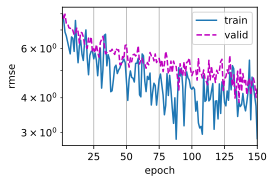

In [25]:

train_ls,test_ls = train(net,loss,train_dataset,test_dataset,num_epochs=epochs,optimizer=optimizer)
d2l.plot(list(range(1, epochs + 1)), [train_ls, test_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                     legend=['train', 'valid'], yscale='log')
# 打印最后一次的结果
print(f'训练log rmse: {float(train_ls[-1]):f}, '
              f'验证log rmse: {float(test_ls[-1]):f}')

In [29]:
test_data_tensor = torch.tensor(valid_data.fillna(0).astype(int).values,dtype=torch.float32)
preds = net(test_data_tensor).detach().numpy() # 预测结果
test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
print(test_data['Sold Price'])


0        124187.289062
1        110984.312500
2        124187.289062
3        124187.289062
4        110984.312500
             ...      
31621    154339.109375
31622    100998.132812
31623    183742.843750
31624    110984.312500
31625    107980.156250
Name: Sold Price, Length: 31626, dtype: float32


In [30]:
submission = pd.concat([test_data['Id'],test_data['Sold Price']],axis=1)
submission.to_csv('submission.csv',index=False)

: 